## **DATA LOADING**

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import io

# Ignore the warnings for cleaner output
warnings.filterwarnings('ignore')

# Define ANSI escape codes
BOLD = '\033[1m'
RESET = '\033[0m' # Resets all formatting (bold, color, etc.)

# Load the data
try:
    orders = pd.read_csv('data_orders.csv', encoding='utf-8')
    offers = pd.read_csv('data_offers.csv', encoding='utf-8')
    df = orders.merge(right = offers, how = 'inner', on = 'order_gk')
    print("Successfully loaded with UTF-8 encoding")
except Exception as e:
    print("UTF-8 failed:", str(e))

Successfully loaded with UTF-8 encoding


## **DATA INSPECTION**

In [2]:
# Dimensions of the DataFrame
print(f"\n{BOLD}DATASET SHAPE:{RESET}", df.shape)

# Check the data type of each column.
print(f"\n{BOLD}DATA TYPES:{RESET}")
print(df.dtypes)

# Display the first 5 rows of the DataFrame.
print(f"\n{BOLD}FIRST 5 ROWS:{RESET}")
print(df.head().to_string())

# Count the number of missing (null) values in each column.
print(f"\n{BOLD}NULL VALUES COUNT:{RESET}")
print(df.isnull().sum())

# Count the number of fully duplicated rows.
print(f"\n{BOLD}DUPLICATE ROWS:{RESET}", df.duplicated().sum())

# Get the number of unique values in each column.
print(f"\n{BOLD}UNIQUE VALUES:{RESET}")
print(df.nunique())

# Generate descriptive statistics for numerical columns
print(f"\n{BOLD}SUMMARY STATISTICS:{RESET}")
print(df.describe().to_string())


DATASET SHAPE: (31268, 9)

DATA TYPES:
order_datetime                    object
origin_longitude                 float64
origin_latitude                  float64
m_order_eta                      float64
order_gk                           int64
order_status_key                   int64
is_driver_assigned_key             int64
cancellations_time_in_seconds    float64
offer_id                           int64
dtype: object

FIRST 5 ROWS:
  order_datetime  origin_longitude  origin_latitude  m_order_eta       order_gk  order_status_key  is_driver_assigned_key  cancellations_time_in_seconds      offer_id
0       18:08:07         -0.978916        51.456173         60.0  3000583041974                 4                       1                          198.0  300050983403
1       20:57:32         -0.950385        51.456843          NaN  3000583116437                 4                       0                          128.0  300050986179
2       20:57:32         -0.950385        51.456843          

## **DATA CLEANING**

#### RENAIMING COLUMNS

In [3]:
df = df.rename(columns = {
    'order_datetime': 'order_time',
    'cancellations_time_in_seconds': 'cancellation_time_in_seconds',
    'm_order_eta': 'order_eta',
    'order_gk': 'order_id'
})

#### TYPE CORRECTIONS

In [4]:
df["order_time"] = pd.to_datetime(df["order_time"], errors="coerce")
df["order_status_key"] = df["order_status_key"].astype("category")
df["is_driver_assigned_key"] = df["is_driver_assigned_key"].astype("category")

#### DATA CORRECTIONS/TRANSFORMATION & VALUE IMPUTATIONS

In [5]:
df["is_driver_assigned"] = np.where(df["is_driver_assigned_key"] == 1, "Yes", "No")
df["order_status"] = np.where(df["order_status_key"] == 4, "Client Cancelled", "System Reject")
df.drop(columns=["is_driver_assigned_key", "order_status_key"], inplace = True)

#### HANDLNG MISSING VALUES

In [6]:
mask = df['cancellation_time_in_seconds'].isnull() & (df['order_status'] == 'System Reject')
df.loc[mask, 'cancellation_time_in_seconds'] = 0

#### OUTLIER DETECTION & HANDLING

In [7]:
# Calculate IQR for cancellation_time_in_seconds
Q1_cancellation = df['cancellation_time_in_seconds'].quantile(0.25)
Q3_cancellation = df['cancellation_time_in_seconds'].quantile(0.75)
IQR_cancellation = Q3_cancellation - Q1_cancellation

# Define bounds for outlier removal for cancellation_time_in_seconds
lower_bound_cancellation = Q1_cancellation - 1.5 * IQR_cancellation
upper_bound_cancellation = Q3_cancellation + 1.5 * IQR_cancellation

# Filter out outliers from the cancellation_time_in_seconds column
df = df[(df['cancellation_time_in_seconds'] >= lower_bound_cancellation) & (df['cancellation_time_in_seconds'] <= upper_bound_cancellation)]

# Display the shape of the filtered DataFrame
print(f"\n{BOLD}SHAPE AFTER IQR OUTLIER REMOVAL FOR CANCELLATION TIME:{RESET}", df.shape)


SHAPE AFTER IQR OUTLIER REMOVAL FOR CANCELLATION TIME: (29407, 9)


## **UNIVARIATE ANALYSIS**

#### NUMERICAL VARIABLES

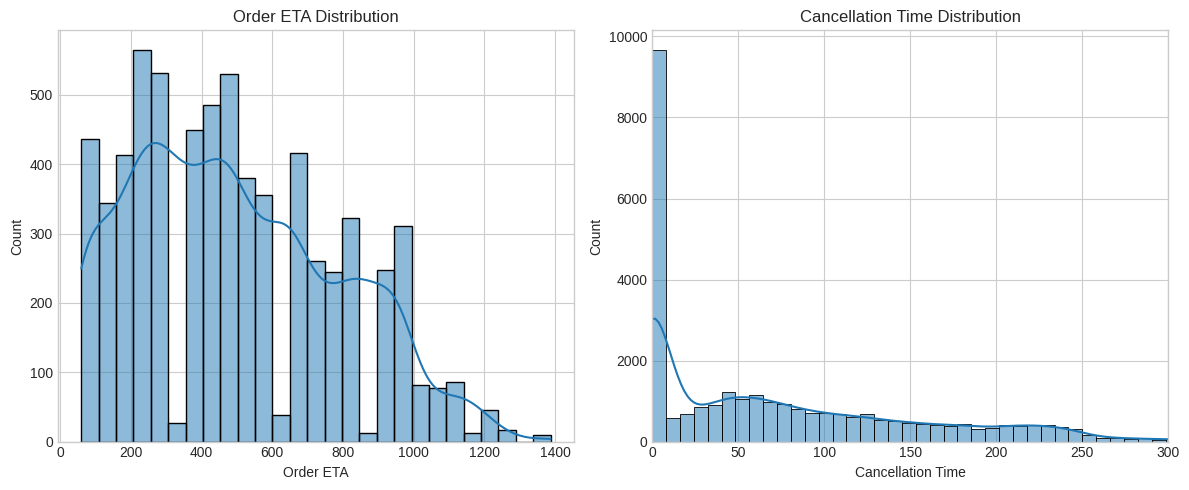

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(ax=axes[0], x='order_eta', kde=True, data=df)
axes[0].set_title('Order ETA Distribution')
axes[0].set_xlabel('Order ETA')
axes[0].set_ylabel('Count')

sns.histplot(ax=axes[1], x='cancellation_time_in_seconds', kde=True, data=df)
axes[1].set_title('Cancellation Time Distribution')
axes[1].set_xlabel('Cancellation Time')
axes[1].set_ylabel('Count')
axes[1].set_xlim([0, 300]) # Further adjust x-axis limit

plt.tight_layout()

#### CATEGORICAL VARIABLES

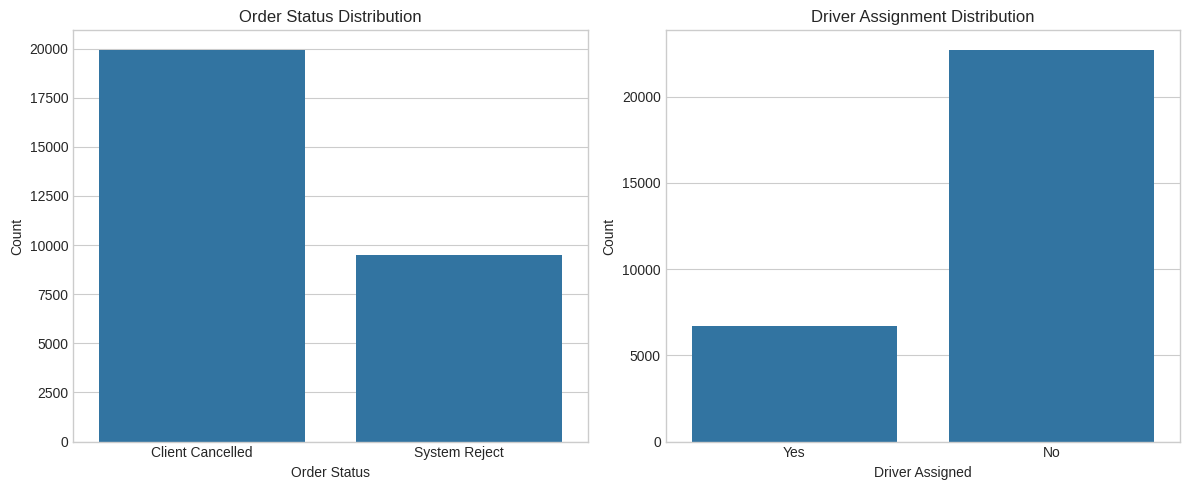

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(ax=axes[0], x='order_status', data=df)
axes[0].set_title('Order Status Distribution')
axes[0].set_xlabel('Order Status')
axes[0].set_ylabel('Count')

sns.countplot(ax=axes[1], x='is_driver_assigned', data=df)
axes[1].set_title('Driver Assignment Distribution')
axes[1].set_xlabel('Driver Assigned')
axes[1].set_ylabel('Count')

plt.tight_layout()

## **BIVARIATE ANALYSIS**


#### NUMERICAL VS NUMERICAL

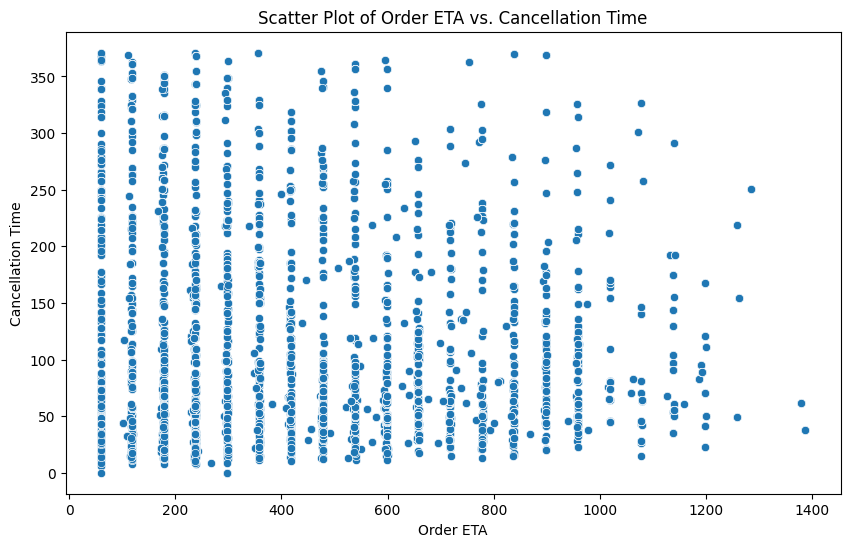

In [10]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='order_eta', y='cancellation_time_in_seconds', data=df)
plt.title('Scatter Plot of Order ETA vs. Cancellation Time')
plt.xlabel('Order ETA')
plt.ylabel('Cancellation Time')
plt.show()

#### NUMERICAL VS CATEGORICAL

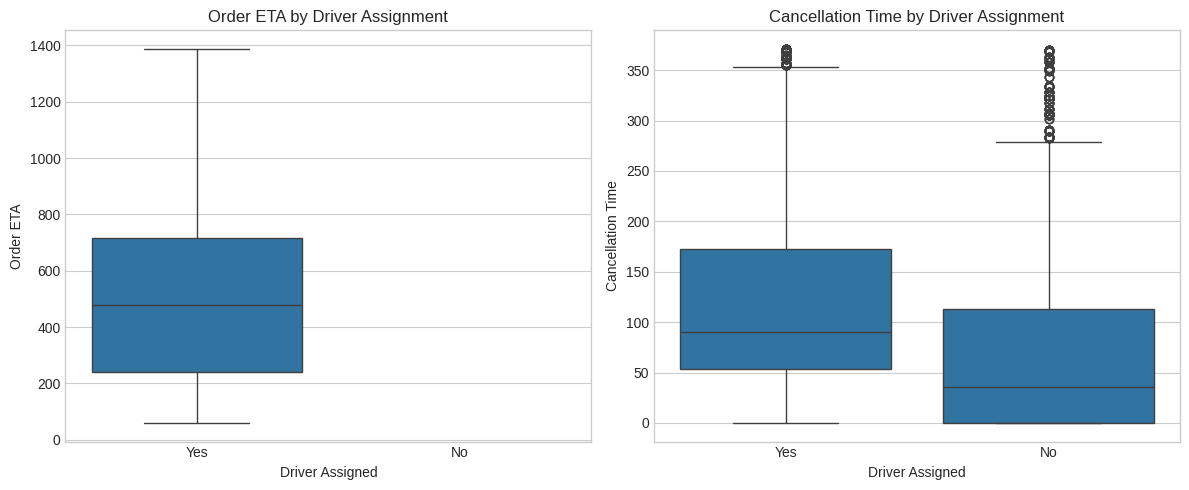

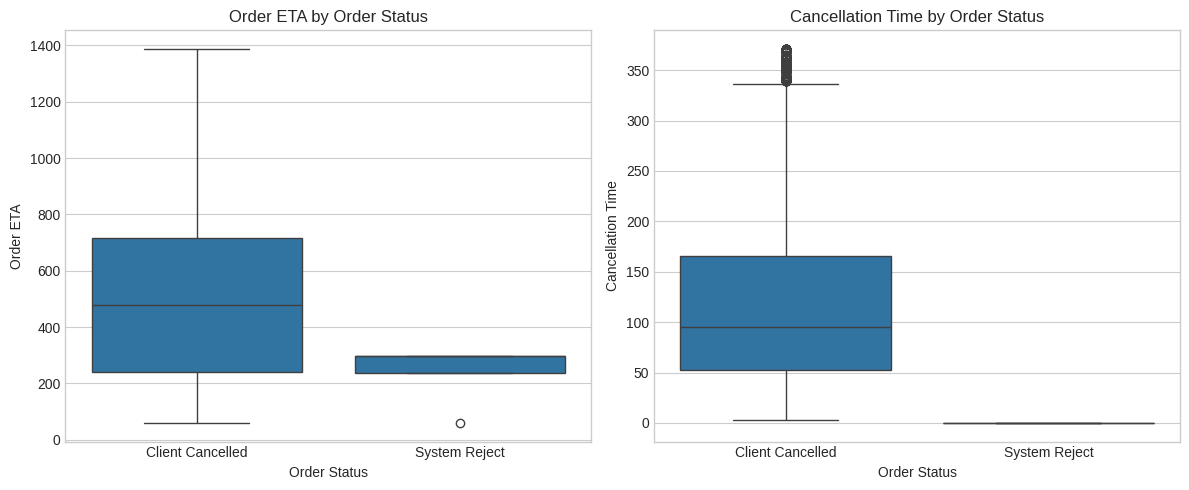

In [63]:
# Box plots for numerical variables by Driver Assignment
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(ax=axes[0], x='is_driver_assigned', y='order_eta', data=df)
axes[0].set_title('Order ETA by Driver Assignment')
axes[0].set_xlabel('Driver Assigned')
axes[0].set_ylabel('Order ETA')

sns.boxplot(ax=axes[1], x='is_driver_assigned', y='cancellation_time_in_seconds', data=df)
axes[1].set_title('Cancellation Time by Driver Assignment')
axes[1].set_xlabel('Driver Assigned')
axes[1].set_ylabel('Cancellation Time')

plt.tight_layout()
plt.show()

# Box plots for numerical variables by Order Status
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(ax=axes[0], x='order_status', y='order_eta', data=df)
axes[0].set_title('Order ETA by Order Status')
axes[0].set_xlabel('Order Status')
axes[0].set_ylabel('Order ETA')

sns.boxplot(ax=axes[1], x='order_status', y='cancellation_time_in_seconds', data=df)
axes[1].set_title('Cancellation Time by Order Status')
axes[1].set_xlabel('Order Status')
axes[1].set_ylabel('Cancellation Time')

plt.tight_layout()
plt.show()

#### CATEGORICAL VS CATEGORICAL

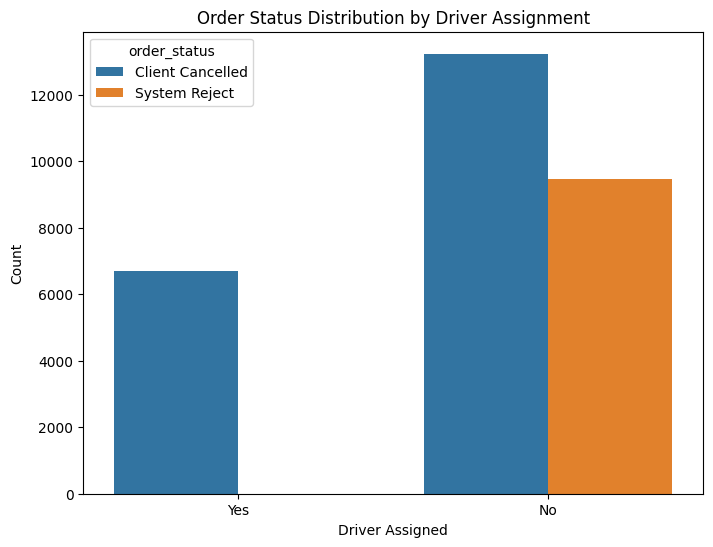

In [12]:
plt.figure(figsize=(8, 6))
sns.countplot(x='is_driver_assigned', hue='order_status', data=df)
plt.title('Order Status Distribution by Driver Assignment')
plt.xlabel('Driver Assigned')
plt.ylabel('Count')
plt.show()

## **MULTIVARIATE ANALYSIS**

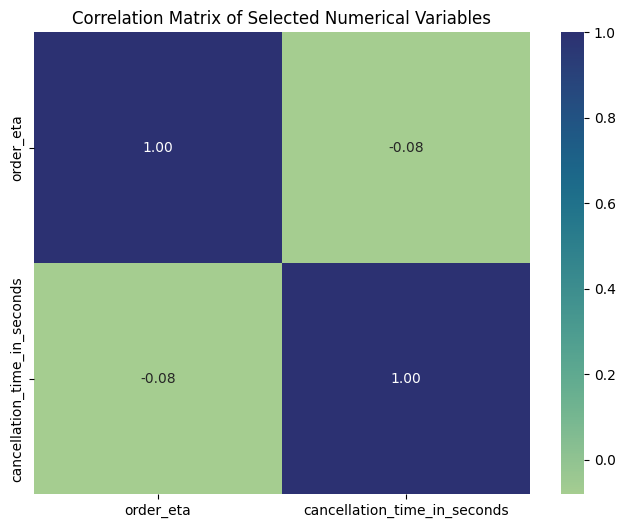

In [13]:
# Select numerical columns for correlation analysis, excluding latitude and longitude
numerical_cols = ['order_eta', 'cancellation_time_in_seconds']

# Calculate the correlation matrix
correlation_matrix = df[numerical_cols].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='crest', fmt=".2f")
plt.title('Correlation Matrix of Selected Numerical Variables')
plt.show()

## **BUSINESS REQUIREMENTS**

📊 1. Distribution of orders according to reasons for failure for the following categories:
- Cancelled before driver assignment
- Cancelled after driver assignment
- System rejection

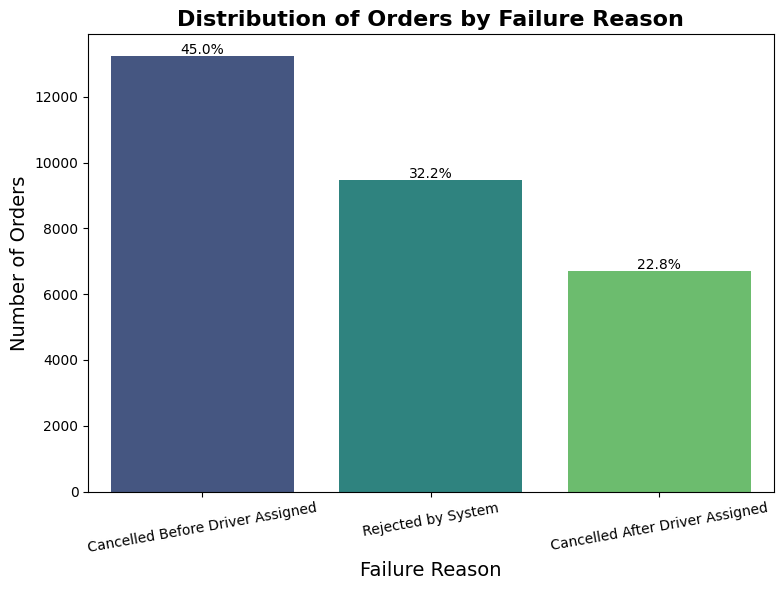

In [14]:
# Define categories of failure
def failure_reason(row):
    if row['order_status'] == 'System Reject':
        return "Rejected by System"
    elif row['order_status'] == 'Client Cancelled' and row['is_driver_assigned'] == 'Yes':
        return "Cancelled After Driver Assigned"
    elif row['order_status'] == 'Client Cancelled' and row['is_driver_assigned'] == 'No':
        return "Cancelled Before Driver Assigned"
    else:
        return "Other"

# Count distributions
df['failure_reason'] = df.apply(failure_reason, axis=1)
failure_counts = df['failure_reason'].value_counts()
failure_percentages = (failure_counts / failure_counts.sum()) * 100
plot_df = pd.DataFrame({
    'Failure Reason': failure_counts.index,
    'Count': failure_counts.values,
    'Percentage': failure_percentages.values
})
plot_df = plot_df.sort_values(by='Count', ascending=False)


# Plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Failure Reason', y='Count', data=plot_df, palette='viridis')
ax.grid(False)
for index, row in plot_df.iterrows():
    ax.text(index, row['Count'] + 50, f"{row['Percentage']:.1f}%", color='black', ha="center")
ax.set_title('Distribution of Orders by Failure Reason', fontsize=16, fontweight='bold')
ax.set_xlabel('Failure Reason', fontsize=14)
ax.set_ylabel('Number of Orders', fontsize=14)
plt.xticks(rotation=10)
ax.tick_params(axis='both', labelsize=10)
plt.tight_layout()

✅Analysis: Failure Distribution
- Cancelled Before Driver Assigned: 13435
- Rejected by System: 9473
- Cancelled After Driver Assigned: 8360

📌Insights:

The largest problem comes from customers cancelling before a driver was even assigned. This suggests issues like:
- Customers getting impatient because no driver was quickly found.
- Poor demand-supply balance (not enough drivers nearby).
- ETA estimates not being accurate or transparent.

‎

📊 2. Distribution Of Failed Orders By Hours

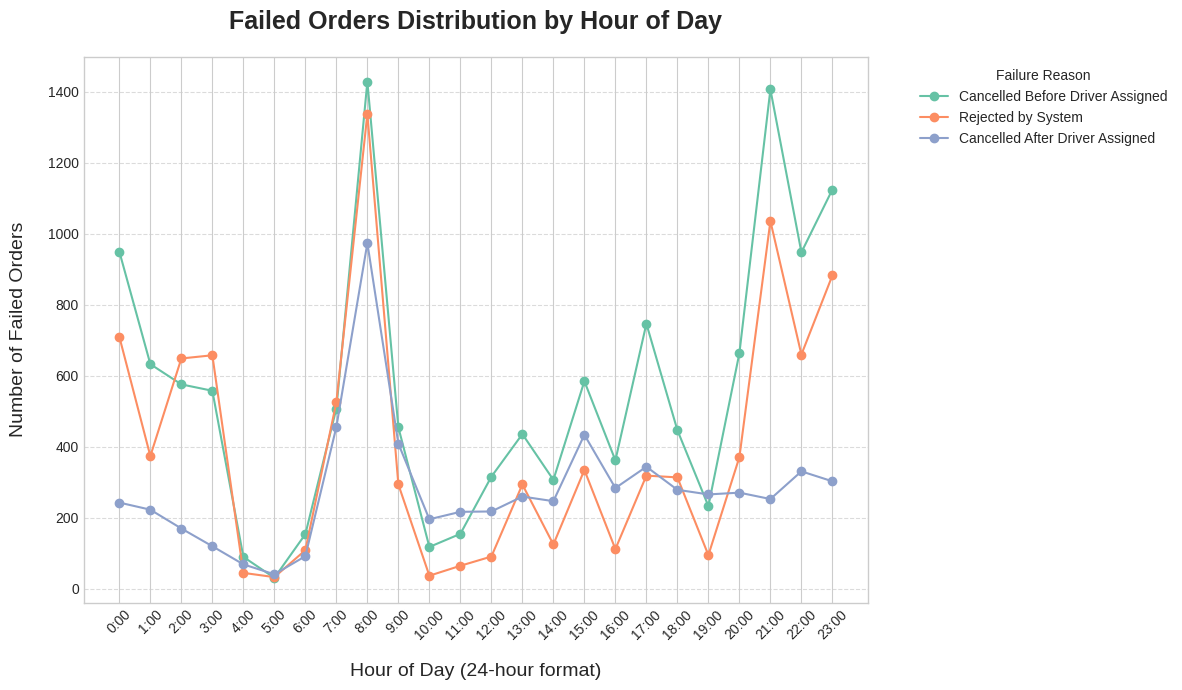

In [15]:
# Extract order_hour
df['order_hour'] = pd.to_datetime(df['order_time'], format="%H:%M:%S").dt.hour

# Count failures by hour and reason
failures_by_hour = df.groupby(['order_hour', 'failure_reason']).size().unstack(fill_value=0)

# Reorder columns to ensure consistency in the plot
failures_by_hour = failures_by_hour[['Cancelled Before Driver Assigned', 'Rejected by System', 'Cancelled After Driver Assigned']]

# Enhancements
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 7))

# Get a color palette from seaborn
colors = sns.color_palette("Set2", n_colors=len(failures_by_hour.columns))
ax = failures_by_hour.plot(kind="line", figsize=(12, 7), marker="o", color=colors, ax=plt.gca())

# Plot
ax.set_title('Failed Orders Distribution by Hour of Day', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Hour of Day (24-hour format)', fontsize=14, labelpad=15)
ax.set_ylabel('Number of Failed Orders', fontsize=14, labelpad=15)
ax.legend(title='Failure Reason', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticks(failures_by_hour.index)
ax.set_xticklabels([f'{int(hour)}:00' for hour in failures_by_hour.index], rotation=45)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

✅ Analysis: Failed Orders by Hour
- Peak failures occur in evening/night hours (18:00 – 23:00).
- Cancelled Before Driver Assigned dominates during late evening — likely due to high demand / driver shortage.
- System Rejections spike in the midnight–early morning (0–4 hrs) when fewer drivers are active.
- Cancelled After Driver Assigned is more spread but still significant in busy hours.

📌 Insight:

- Evenings → high cancellations before assignment → suggests driver supply shortage at peak times.
- Night/Morning → system rejections → possibly system auto-cancels due to no available drivers.

‎

📊 3. Average time to cancellation with and without driver, by the hour.

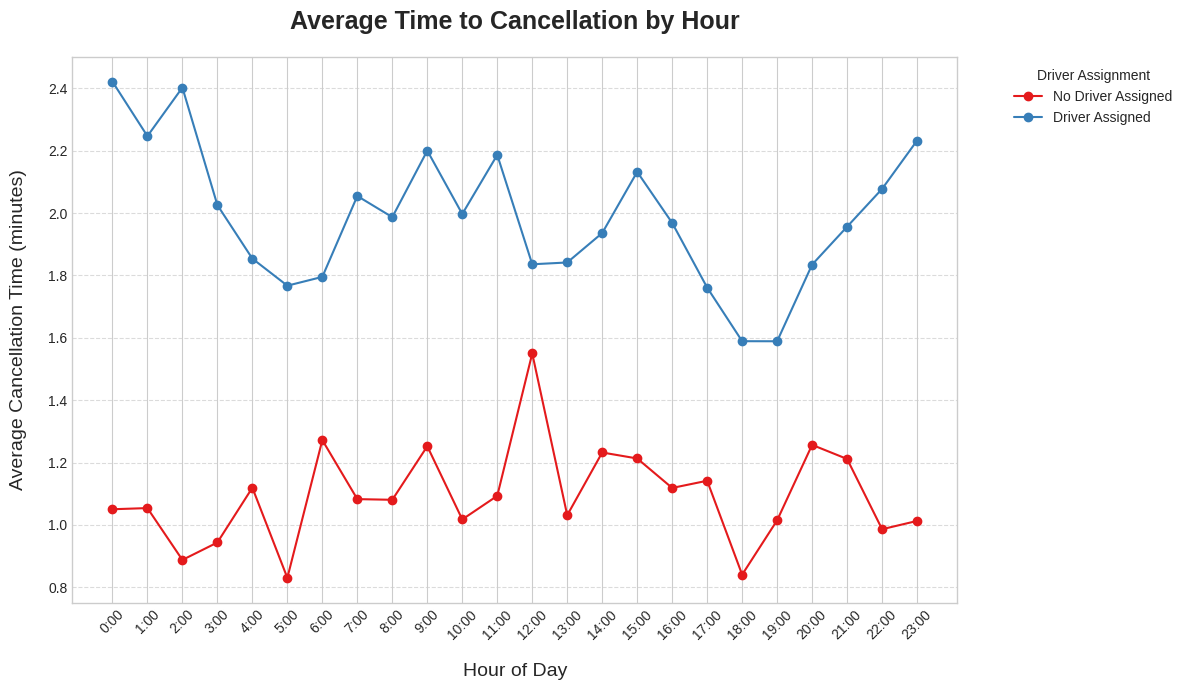

In [16]:
# Extract order_hour
df['order_hour'] = pd.to_datetime(df['order_time'], format="%H:%M:%S").dt.hour

# Group by hour and driver assignment
avg_cancel_time = (
    df
    .groupby(['order_hour','is_driver_assigned'])['cancellation_time_in_seconds']
    .mean()
    .unstack()
)

# Rename columns for readability
avg_cancel_time.columns = ['No Driver Assigned', 'Driver Assigned']

# Convert seconds to minutes for better readability on the y-axis
avg_cancel_time = avg_cancel_time / 60

# Plot
plt.figure(figsize=(12, 7))
# Get a color palette from seaborn
colors = sns.color_palette("Set1", n_colors=2)
ax = avg_cancel_time.plot(kind="line", figsize=(12, 7), marker="o", color=colors, ax=plt.gca())

# Plot
ax.set_title('Average Time to Cancellation by Hour', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Hour of Day', fontsize=14, labelpad=15)
ax.set_ylabel('Average Cancellation Time (minutes)', fontsize=14, labelpad=15)
ax.legend(title='Driver Assignment', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticks(avg_cancel_time.index)
ax.set_xticklabels([f'{int(hour)}:00' for hour in avg_cancel_time.index], rotation=45)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

✅ Analysis: Cancellation Time with/without Driver
1. No Driver Assigned:
 - Cancellation time is short (typically in few minutes)
2. Driver Assigned:
 - Cancellation time is longer (customers wait more).
3. Hourly Trends:
 - Morning (7 - 10 AM): Customers may be slightly less patient even if a driver is assigned → they need urgent commutes.
 - Evening (6 - 10 PM): Patience increases (longer cancellation times) because customers may be heading home, less urgent.
 - Late Night (12 - 4 AM): Short cancellation times without drivers (likely due to low driver availability). System rejections dominate here as seen in Q2.

📌 Insights:
 - Customers show clear behavioral difference depending on whether a driver is assigned.
 - The company should focus on faster driver assignment, this alone may reduce ealry cancellation significantly.
 - If driver supply is low at certain hours, showing a transparent ETA might also help retain users instead of quick cancellations.

‎

📊 4. Distribution Of Average ETA By Hours

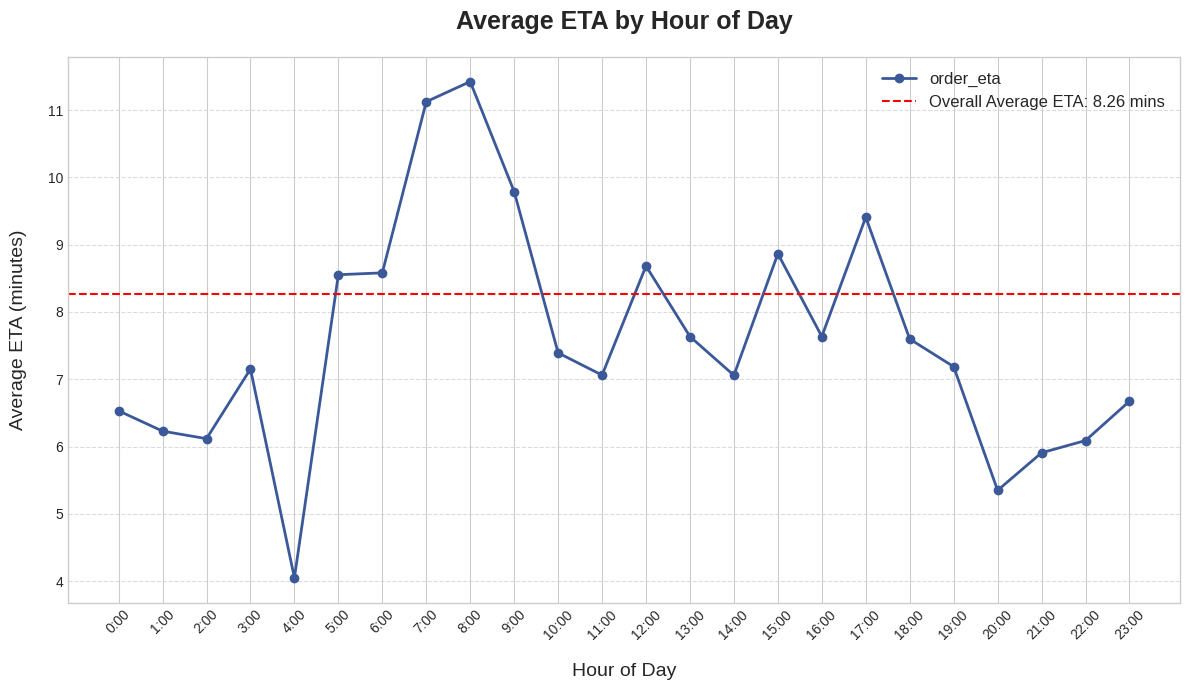

In [17]:
# Convert order_time to datetime and extract hour
df['order_hour'] = pd.to_datetime(df['order_time'], format="%H:%M:%S").dt.hour

# Calculate average ETA by hour, dropping null values
avg_eta_by_hour = df.groupby('order_hour')['order_eta'].mean().dropna()

# Convert ETA from seconds to minutes
avg_eta_by_hour_minutes = avg_eta_by_hour / 60

# Calculate the overall average ETA in minutes for a horizontal line
overall_avg_eta_minutes = df['order_eta'].mean() / 60

# Plot with improvements
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 7))

# Plot the main line
ax = avg_eta_by_hour_minutes.plot(kind="line", marker="o", color="#3b5998", linewidth=2)

# Add a horizontal line for the overall average
ax.axhline(y=overall_avg_eta_minutes, color='red', linestyle='--', label=f'Overall Average ETA: {overall_avg_eta_minutes:.2f} mins')

# Set title and labels
ax.set_title('Average ETA by Hour of Day', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Hour of Day', fontsize=14, labelpad=15)
ax.set_ylabel('Average ETA (minutes)', fontsize=14, labelpad=15)

# Customize x-ticks
ax.set_xticks(avg_eta_by_hour_minutes.index)
ax.set_xticklabels([f'{int(hour)}:00' for hour in avg_eta_by_hour_minutes.index], rotation=45)

# Customize legend and grid
ax.legend(loc='upper right', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

✅ Analysis:
- Low ETA: Usually during off hours (early-morning, evening), when traffic is lighter and driver supply is balanced.
- High ETA: Often during rush hours (7 - 10 AM, 3 - 6 PM) when:
  - Demand is high.
  - Trafic congestion slows down drivers.

📌 Insights:
- Driver allocation strategy should focus on reduing ETAs during peak hours.
- High ETA correlates with higher cancellation.

‎

📊 5. Using h3 and folium bucket every order into a hexagon on the map. Count how many orders fall in each hexagon and find the minimum number of hexagons that together contain 80% of all orders. Plot these hexagons on a map and color them by failure density.

In [56]:
!pip install h3

import h3
import folium
import branca.colormap as cm

# Step 1: Assign each order to an H3 hexagon at resolution 8
df['hex8'] = df.apply(lambda row: h3.latlng_to_cell(row['origin_latitude'], row['origin_longitude'], 8), axis=1)

# Step 2: Count orders per hex
hex_counts = df['hex8'].value_counts().reset_index()
hex_counts.columns = ['hex8', 'order_count']

# Step 3: Calculate cumulative distribution to find 80%
hex_counts['cum_pct'] = hex_counts['order_count'].cumsum() / hex_counts['order_count'].sum()

# Find number of hexes covering 80% of orders
num_hexes_80 = (hex_counts['cum_pct'] <= 0.8).sum()
print(f"Number of hexes covering 80% of orders: {num_hexes_80}")

# Step 4: Merge with failed order counts
failures_by_hex = df.groupby('hex8').size().reset_index(name='fail_count')
hex_summary = hex_counts.merge(failures_by_hex, on='hex8')

# Step 5: Visualize with Folium
max_fail = hex_summary['fail_count'].max()
color_scale = cm.linear.plasma.scale(0, max_fail)
color_scale.caption = 'Failure Count'
# Center map on mean location
map_center = [df['origin_latitude'].mean(), df['origin_longitude'].mean()]
map = folium.Map(location=map_center, zoom_start=12, tiles="cartodbpositron")

# Add hexagons to map
for _, row in hex_summary.iterrows():
    coords = h3.cell_to_boundary(row['hex8'])
    polygon =  [(lat, lng) for lat, lng in coords]
    folium.Polygon(
        locations=polygon,
        color='black',
        fill=True,
        fill_color=color_scale(row['fail_count']),
        fill_opacity=0.7,
        weight=1,
        tooltip=f"Fails: {row['fail_count']}, Orders: {row['order_count']}"
    ).add_to(map)

# Add color scale legend to map
color_scale.add_to(m)

# Display map
map

Number of hexes covering 80% of orders: 20


✅ Analysis:

- Order Concentration: Usually, a small number of hexes cover 80% of order.
- Failure Hotspots:
  - Darker hexagons = Higher failure counts
  - Failure clusters in high-demand areas, where, drivers supply is insufficient during peak hours.
  - System rejections are triggered because no driver accepts the ride.

📌 Insights:
- Focus driver incentives in these key areas to meet demand.
- Pre-position drivers during peak, or use dynamic pricing to balance supply.
- Consider partnerships with navigation to improve accuracy and ealry ETA.

‎